# Black-Litterman Model
Implementation of the Black-Litterman on an optimal portfolio:
- EGB0          -> ICE BoA Euro Treasury Bill Index
- GJI0          -> ICE BoA All Maturity Italy Government Index
- JHUCXEHE      -> JP Morgan GBI Global ex-EMU Hedged EUR
- JEEXXITE      -> JP Morgan GBI EMU ex Italy EUR
- GCXZ          -> ICE BoA Global Large Cap Corporate ex-Euro Index
- NDDLEMU       -> MSCI EMU Net Total Return Local Index
- MXWOHEUR      -> MSCI World 100% Hedged Euro Net Total Return Index

In the Black-Litterman a key aspect of the model calculation is the use Views. These are the opinions one investor has on the market performance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set_palette('cubehelix')
plt.rcParams['figure.figsize'] = [8, 4.5]

C:\Users\Gianlorenzo\AppData\Local\Temp\ipykernel_3048\4148815678.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
TAU = 0.05

date = "2022-09-30"
oneyearbefore = date[:2] + str(int(date[2:4]) - 1) + date[4:]
nviews = 4

In [3]:
result = pd.DataFrame(columns=["Gestore", "Market pft excess return", "BL pft excess return",
                               "GJI0", "JHUCXEHE", "JEEXXITE", "ER00", "GCXZ", "NDDLEMU", "MXWOHEUR"])

In [5]:
indices_price = pd.read_excel("indices_values.xlsx", index_col=0)
indices_price

,EGB0,GJI0,JHUCXEHE,JEEXXITE,ER00,GCXZ,NDDLEMU,MXWOHEUR
1998-12-31,100.000,NaN,109.39708,NaN,121.597,100.000,182.882,99.846298
1999-01-31,100.281,NaN,110.03529,NaN,123.260,100.840,187.796,103.147233
1999-02-28,100.486,NaN,108.28100,NaN,122.236,99.701,184.798,101.659342
1999-03-31,100.803,NaN,109.16363,NaN,122.946,100.624,188.302,106.134011
1999-04-30,101.072,NaN,109.83241,NaN,124.372,101.387,197.361,110.787836
...,...,...,...,...,...,...,...,...
2022-08-31,142.359,235.939,211.71000,205.062,262.567,237.695,394.777,293.070000
2022-09-30,142.002,228.623,204.90000,197.259,253.448,224.567,369.814,267.830000
2022-10-31,142.054,230.922,203.31000,197.133,253.929,222.419,399.106,286.380000
2022-11-30,142.178,236.784,206.77000,201.482,261.012,231.978,432.514,301.790000


In [80]:
market_weights = pd.read_excel(r"C:\Users\Gianlorenzo\Dropbox\Giallo\UNIMIB\Tesi\sources\Black-Litterman\dati_indici.xlsx", sheet_name=1)
market_weights

,EGB0,GJI0,JHUCXEHE,JEEXXITE,ER00,GCXZ,NDDLEMU,MXWOHEUR
0,0,0.058533,0.181867,0.122978,0.145089,0.145533,0.0925,0.2535


In [8]:
risk_free_realized_return = (indices_price.loc[date, 'EGB0'] / indices_price.loc[oneyearbefore, 'EGB0']) - 1
risk_free_realized_return

-0.009617731777571525

In [82]:
risk_free_realized_return

-0.009617731777571525

In [9]:
risk_free_rtns = indices_price["EGB0"].pct_change()
risk_free_rtns.dropna(inplace=True)
risk_free_rtns.drop(risk_free_rtns[risk_free_rtns.index < "31-01-01"].index, inplace=True)
risk_free_rtns = pd.DataFrame(risk_free_rtns)
risk_free_rtns

,EGB0
2001-01-31,0.003784
2001-02-28,0.003267
2001-03-31,0.004305
2001-04-30,0.002513
2001-05-31,0.004939
...,...
2022-08-31,-0.000330
2022-09-30,-0.002508
2022-10-31,0.000366
2022-11-30,0.000873


In [10]:
indices_price.drop(columns=['EGB0'], inplace=True)
indices_rtns = indices_price.pct_change()
indices_rtns.dropna(how='any', inplace=True)
indices_rtns.drop(indices_rtns[indices_rtns.index > date].index, inplace=True)
indices_rtns

,GJI0,JHUCXEHE,JEEXXITE,ER00,GCXZ,NDDLEMU,MXWOHEUR
2001-01-31,0.007540,0.009754,0.007920,0.011731,0.019301,0.015162,0.026230
2001-02-28,0.003485,0.011109,0.005169,0.005140,0.006239,-0.088397,-0.079262
2001-03-31,0.006909,0.004911,0.007344,0.008843,0.006991,-0.038520,-0.051325
2001-04-30,-0.008882,-0.007372,-0.012807,-0.007739,-0.001300,0.077763,0.068488
2001-05-31,0.003173,0.006091,0.001757,0.006454,0.010142,-0.021989,-0.006427
...,...,...,...,...,...,...,...
2022-05-31,-0.017999,-0.002669,-0.017671,-0.012832,0.002963,0.005689,-0.002962
2022-06-30,-0.009185,-0.012550,-0.019922,-0.034253,-0.025935,-0.092116,-0.080629
2022-07-31,0.015726,0.015373,0.046062,0.046397,0.027431,0.073002,0.079712
2022-08-31,-0.038683,-0.025725,-0.051912,-0.042418,-0.029638,-0.050345,-0.036239


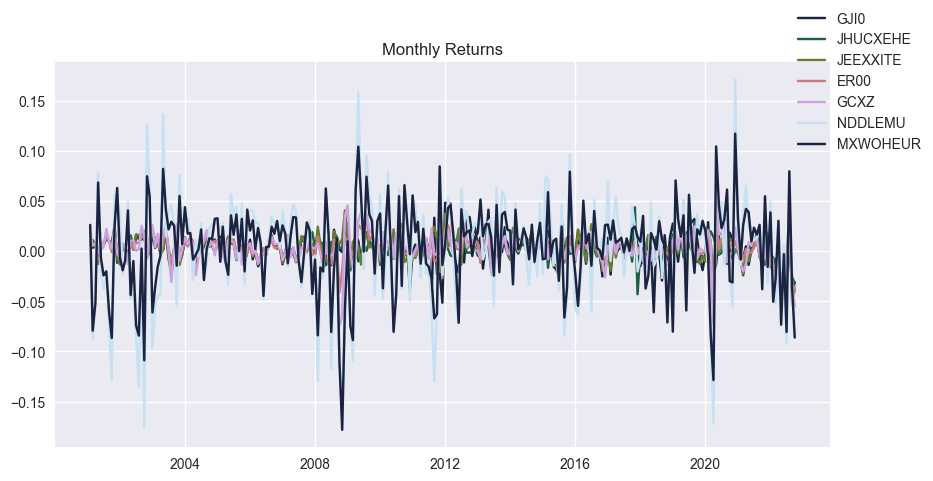

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_title('Monthly Returns', loc='center', fontsize='large')
ax.plot(indices_rtns)
fig.legend(['GJI0', 'JHUCXEHE', 'JEEXXITE', 'ER00', 'GCXZ', 'NDDLEMU', 'MXWOHEUR'])

In [14]:
# From each monthly return of every indices subtract the corresponding risk-free monthly return 
for i, row in indices_rtns.iterrows():
    rf_rtn = risk_free_rtns.at[i, 'EGB0']
    indices_rtns.at[i, 'GJI0'] -= rf_rtn
    indices_rtns.at[i, 'JHUCXEHE'] -= rf_rtn
    indices_rtns.at[i, 'JEEXXITE'] -= rf_rtn
    indices_rtns.at[i, 'ER00'] -= rf_rtn
    indices_rtns.at[i, 'GCXZ'] -= rf_rtn
    indices_rtns.at[i, 'NDDLEMU'] -= rf_rtn
    indices_rtns.at[i, 'MXWOHEUR'] -= rf_rtn

In [15]:
indices_rtns

,GJI0,JHUCXEHE,JEEXXITE,ER00,GCXZ,NDDLEMU,MXWOHEUR
2001-01-31,0.003756,0.005970,0.004136,0.007948,0.015517,0.011378,0.022446
2001-02-28,0.000218,0.007842,0.001902,0.001873,0.002972,-0.091665,-0.082529
2001-03-31,0.002605,0.000606,0.003039,0.004538,0.002686,-0.042825,-0.055629
2001-04-30,-0.011395,-0.009884,-0.015319,-0.010252,-0.003813,0.075250,0.065975
2001-05-31,-0.001766,0.001152,-0.003182,0.001515,0.005203,-0.026928,-0.011366
...,...,...,...,...,...,...,...
2022-05-31,-0.017033,-0.001702,-0.016704,-0.011865,0.003929,0.006656,-0.001995
2022-06-30,-0.008042,-0.011407,-0.018780,-0.033110,-0.024793,-0.090974,-0.079487
2022-07-31,0.016190,0.015836,0.046525,0.046861,0.027894,0.073466,0.080175
2022-08-31,-0.038353,-0.025395,-0.051582,-0.042088,-0.029308,-0.050015,-0.035909


In [23]:
portfolio_weights = market_weights.drop(columns=['EGB0'])
portfolio_weights = portfolio_weights.rename({"Weight":"Weights"})

In [24]:
portfolio_weights.T.style.format({
    'Weights': '{:,.2%}'.format,
})

,Weights
GJI0,5.85%
JHUCXEHE,18.19%
JEEXXITE,12.30%
ER00,14.51%
GCXZ,14.55%
NDDLEMU,9.25%
MXWOHEUR,25.35%


Calculate the benchmark excess return

In [25]:
benchmark_er = np.dot(indices_rtns, np.transpose(portfolio_weights))

Compute historical price series of the portfolio

In [26]:
benchmark_series = np.empty(len(benchmark_er) + 1)
benchmark_series[0] = 100

In [27]:
for i in range(benchmark_series.size):
    if i != 0:
        benchmark_series[i] = benchmark_series[i - 1] * (1 + benchmark_er[i - 1])

Compute the log monthly returns of the benchmark

In [28]:
log_returns = np.empty(len(benchmark_er))

for i in range(log_returns.size):
    log_returns[i] = np.log(benchmark_series[i + 1] / benchmark_series[i])

In [29]:
# Mean monthly return of the optimal portfolio
mean_monthly_return = np.mean(log_returns[:246])

In [30]:
mean_monthly_return

0.002607553496088357

In [31]:
# Portfolio variance
monthly_variance = np.var(log_returns[:246])

In [32]:
monthly_variance

0.00028174896837214925

In [34]:
# Portfolio Lambda
lmd = (mean_monthly_return / monthly_variance) * 12

In [35]:
lmd

111.05858571141214

In [36]:
# Covariance Matrix
cov_matrix = indices_rtns.loc[:oneyearbefore, :].cov()
cov_matrix

,GJI0,JHUCXEHE,JEEXXITE,ER00,GCXZ,NDDLEMU,MXWOHEUR
GJI0,0.000203,0.000038,0.000094,0.000073,0.000077,0.000083,0.000044
JHUCXEHE,0.000038,0.000099,0.000074,0.000030,0.000068,-0.000156,-0.000128
JEEXXITE,0.000094,0.000074,0.000125,0.000069,0.000083,-0.000101,-0.000085
ER00,0.000073,0.000030,0.000069,0.000107,0.000130,0.000168,0.000152
GCXZ,0.000077,0.000068,0.000083,0.000130,0.000222,0.000221,0.000218
NDDLEMU,0.000083,-0.000156,-0.000101,0.000168,0.000221,0.002672,0.001980
MXWOHEUR,0.000044,-0.000128,-0.000085,0.000152,0.000218,0.001980,0.001726


In [38]:
# sigma matrix * tau
cov_tau = cov_matrix * TAU

In [39]:
market_implied_rtns = lmd * np.matmul(cov_matrix, np.transpose(np.array(portfolio_weights)))
market_implied_rtns.rename(columns={0:'"Equilibrium" Returns'}, inplace=True)

In [40]:
market_neutral_Q = np.zeros(nviews, dtype=float)

market_neutral_Q[0] = market_implied_rtns.iloc[5] - market_implied_rtns.iloc[6]
market_neutral_Q[1] = market_implied_rtns.iloc[0] - market_implied_rtns.iloc[2]
market_neutral_Q[2] = market_implied_rtns.iloc[3] - (0.25 * market_implied_rtns.iloc[0] + 0.75 * market_implied_rtns.iloc[2])
market_neutral_Q[3] = market_implied_rtns.iloc[5] - (0.25 * market_implied_rtns.iloc[0] + 0.75 * market_implied_rtns.iloc[2])

In [46]:
views = pd.DataFrame([{"0": 0.0549, "1": 0, "2": 0.02, "3": 0.18}])
views

,0,1,2,3
0,0.0549,0,0.02,0.18


In [48]:
i = 0

Q = np.zeros(nviews, dtype=float)

if views.iloc[i][0] != 0:
    Q[0] = views.iloc[i][0]
else:
    Q[0] = market_neutral_Q[0]

if views.iloc[i][1] != 0:
    Q[1] = views.iloc[i][1]
else:
    Q[1] = market_neutral_Q[1]

if views.iloc[i][2] != 0:
    Q[2] = views.iloc[i][2]
else:
    Q[2] = market_neutral_Q[2]

if views.iloc[i][3] != 0:
    Q[3] = views.iloc[i][3]
else:
    Q[3] = market_neutral_Q[3]

In [49]:
Q_df = pd.DataFrame(Q, index=[1, 2, 3, 4], columns=["Views"])
Q_df

,Views
1,0.054900
2,0.005013
3,0.020000
4,0.180000


In [50]:
p_array = np.array([[0, 0, 0, 0, 0, 1, -1],
                    [1, 0, -1, 0, 0, 0, 0],
                    [-0.25, 0, -0.75, 1, 0, 0, 0],
                    [-0.25, 0, -0.75, 0, 0, 1, 0]])

P_matrix = pd.DataFrame(p_array, columns=['GJI0', 'JHUCXEHE', 'JEEXXITE', 'ER00', 'GCXZ', 'NDDLEMU', 'MXWOHEUR'])
P_matrix

,GJI0,JHUCXEHE,JEEXXITE,ER00,GCXZ,NDDLEMU,MXWOHEUR
0,0.00,0.0,0.00,0.0,0.0,1.0,-1.0
1,1.00,0.0,-1.00,0.0,0.0,0.0,0.0
2,-0.25,0.0,-0.75,1.0,0.0,0.0,0.0
3,-0.25,0.0,-0.75,0.0,0.0,1.0,0.0


In [51]:
np.matmul(np.array(Q_df.T), P_matrix)

,GJI0,JHUCXEHE,JEEXXITE,ER00,GCXZ,NDDLEMU,MXWOHEUR
0,-0.044987,0.0,-0.155013,0.02,0.0,0.2349,-0.0549


In [52]:
Omega = np.matmul(np.matmul(np.array(P_matrix), cov_tau), np.transpose(np.array(P_matrix)))
Omega = np.diag(np.diag(Omega))
Omega

array([[2.18886617e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.96237552e-06, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.28001792e-06, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.44995646e-04]])

In [53]:
bl1 = np.linalg.inv(np.linalg.inv(np.array(cov_tau)) + np.matmul(np.matmul(np.transpose(np.array(P_matrix)), np.linalg.inv(Omega)), P_matrix))

In [54]:
bl2 = np.matmul(np.linalg.inv(np.array(cov_tau)), np.array(market_implied_rtns)).flatten() + np.matmul(np.matmul(np.transpose(np.array(P_matrix)), np.linalg.inv(Omega)), Q).flatten()

In [59]:
bl_excess_returns = pd.DataFrame(np.matmul(bl1, bl2),
                                 index=['GJI0', 'JHUCXEHE', 'JEEXXITE', 'ER00', 'GCXZ', 'NDDLEMU', 'MXWOHEUR'],
                                 columns=['Expected return'])

In [60]:
bl_excess_returns.style.format({
    'Expected return': '{:,.2%}'.format,
})

,Expected return
GJI0,0.49%
JHUCXEHE,-0.50%
JEEXXITE,-0.21%
ER00,1.53%
GCXZ,2.12%
NDDLEMU,14.92%
MXWOHEUR,11.10%
